In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/stroke_data.csv")
print(df.shape)
print(df.info())


(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [4]:
#preproceeesinh
# %pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1. Drop ID
df = df.drop("id", axis=1)

# 2. Handle missing BMI -> fill with median
df["bmi"].fillna(df["bmi"].median(), inplace=True)

# 3. Separate features and target
X = df.drop("stroke", axis=1)
y = df["stroke"]

# 4. Categorical and numeric columns
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
num_cols = ["age", "avg_glucose_level", "bmi"]

# 5. Preprocessor: OneHot for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Fit and transform
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# 8. Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))

Before SMOTE: stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
After SMOTE: stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


C:\Users\moham\AppData\Local\Temp\ipykernel_11660\1908140264.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(df["bmi"].median(), inplace=True)


In [5]:
# model building and training
import numpy as np
print("X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)
print("y_train_res distribution:\n", np.bincount(y_train_res))
print("y_test distribution:\n", np.bincount(y_test))
# NaN checks
print("Any NaNs in X_train_res?", np.isnan(X_train_res).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())

# our data is perfectly balancedd


X_train_res shape: (7778, 14)
X_test shape: (1022, 14)
y_train_res distribution:
 [3889 3889]
y_test distribution:
 [972  50]
Any NaNs in X_train_res? False
Any NaNs in X_test? False


In [ ]:
#BAseline model Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

clf = LogisticRegression(max_iter=2000, random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba))

performace increse with xgboost algo




In [ ]:
# Improve thhe model performance from other models

# %pip install imbalanced-learn xgboost
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,   # since SMOTE balanced the dataset
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train_res, y_train_res)


In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Reports
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC:", average_precision_score(y_test, y_prob))


Further Improvement



In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))



In [ ]:
neg, pos = np.bincount(y_train)   # count class distribution in training set
scale = neg / pos
print("scale_pos_weight:", scale)


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("PR AUC:", average_precision_score(y_test, y_probs))


Create SMOTE AND XGboosst

In [ ]:
# ensure X is a DataFrame
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Train-test split keeps X as DataFrame
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(type(X_train))  # should print <class 'pandas.core.frame.DataFrame'>


In [ ]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
    ]
)

pipeline = ImbPipeline([
    ("pre", preprocessor),     # converts DF -> numeric array
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])



In [ ]:
param_dist = {
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [200, 500, 1000],
    "xgb__subsample": [0.7, 0.8, 1.0],
    "xgb__colsample_bytree": [0.7, 0.8, 1.0],
    "xgb__scale_pos_weight": [15, 20, 25]  # imbalance ratio ~ 1:20
}


In [ ]:

from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring="f1",
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=1,             # <-- use 1 while debugging
    random_state=42,
    error_score='raise'   # <-- raise errors instead of hiding them
)

search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)



FROM ABOVE WE GET THE BEST PARAMETERS TO TRAIN XGBOOST MODEL

In [ ]:
best_model = search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))


VISUALIZING 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Improve recall by altering the threshold probabilty

In [ ]:
# predicted probability for the positive class (stroke=1)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Example probabilities:", y_proba[:10])

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Check number of thresholds
print("Number of thresholds:", len(thresholds))


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Decision Threshold")
plt.legend()
plt.show()


In [ ]:
# Example: pick threshold where recall ~0.7
custom_threshold = 0.35 # adjust based on your plot
y_pred_custom = (y_proba >= custom_threshold).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (Custom Threshold):")
print(classification_report(y_test, y_pred_custom))

print("Confusion Matrix (Custom Threshold):")
print(confusion_matrix(y_test, y_pred_custom))


SO to have balanced output for each class we stick with 0.3 threshold value


NExt task is to give top 5 features that are affecting model

In [32]:
print(best_model.predict(X_test))

[0 0 0 ... 0 0 1]


In [ ]:
%pip install shap





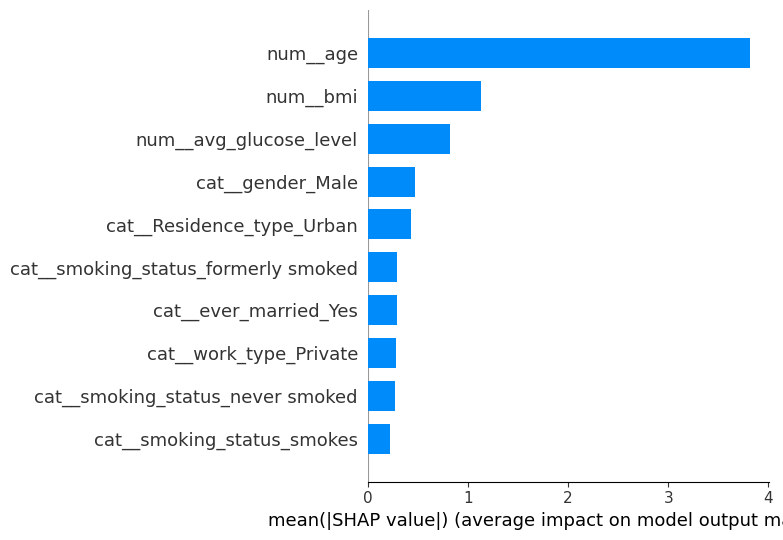

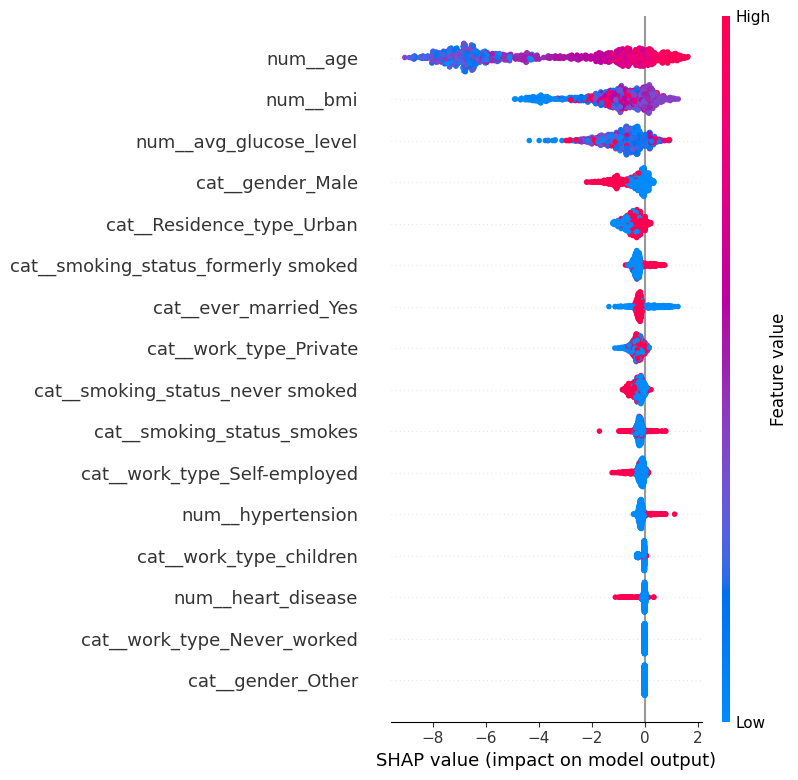

Top 5 Features by SHAP Importance:
                      feature  mean_abs_shap
0                    num__age       3.817769
4                    num__bmi       1.132865
3      num__avg_glucose_level       0.821860
5            cat__gender_Male       0.472754
12  cat__Residence_type_Urban       0.433244


In [39]:
# ===============================
# SHAP Explainability for XGBoost (Pipeline-friendly)
# ===============================

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract trained XGBoost model from pipeline
model = best_model.named_steps['xgb']  # raw XGBClassifier

# Transform test set using pipeline preprocessor
preprocessor = best_model.named_steps['pre']
X_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
else:
    feature_names = [f"f{i}" for i in range(X_transformed.shape[1])]

# Convert to DataFrame with correct column names
X_df = pd.DataFrame(X_transformed, columns=feature_names)

# ===============================
# Create SHAP Explainer
# ===============================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_df)

# ===============================
# Summary Plot (Top Features - Bar)
# ===============================
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_df, plot_type="bar", max_display=10)
plt.show()

# ===============================
# Optional: SHAP summary dot plot
# ===============================
shap.summary_plot(shap_values, X_df)

# ===============================
# Force Plot for One Example
# ===============================
index = 0
patient_data = X_df.iloc[index:index+1]
patient_shap = explainer.shap_values(patient_data)

# Display force plot in notebook
shap.initjs()
shap.force_plot(explainer.expected_value, patient_shap, patient_data)

# ===============================
# Top 5 features by mean absolute SHAP values
# ===============================
shap_importance = pd.DataFrame({
    'feature': X_df.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

print("Top 5 Features by SHAP Importance:")
print(shap_importance.head(5))
